In [1]:
import numpy as np
import cupy as cp
import dxchange
import matplotlib.pyplot as plt
from holotomo.proc import linear, dai_yuan
from holotomo.tomo import R,RT
from holotomo.chunking import gpu_batch

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


npos = 1  # number of code positions 

detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 12e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad
print(distances+distances2)
print(1/norm_magnifications)
print(norm_magnifications2)

[0.00146594]
[1.]
[0.12331803]


In [3]:
psi_abs = dxchange.read_tiff('data/rec_abs.tiff')[:]
psi_angle = dxchange.read_tiff('data/rec_angle.tiff')[:]
psi = psi_abs*np.exp(1j*psi_angle)

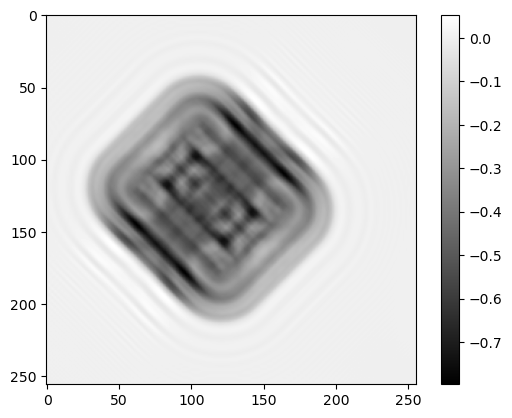

In [4]:
plt.imshow(np.angle(psi[0]),cmap='gray')
plt.colorbar()

In [5]:
def mshow(a):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    if isinstance(a,cp.ndarray):
        a = a.get()
    im = axs[0].imshow(np.real(a), cmap='gray')
    axs[0].set_title('reconstructed real')
    fig.colorbar(im)
    im = axs[1].imshow(np.imag(a), cmap='gray')
    axs[1].set_title('reconstructed imag')
    fig.colorbar(im)
    plt.show()

In [6]:

def mlog(psi):
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    return res

def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    return -1j * wavelength / (2*cp.pi) * mlog(psi) / voxelsize


0) gamma=1, err=4.34618e-03


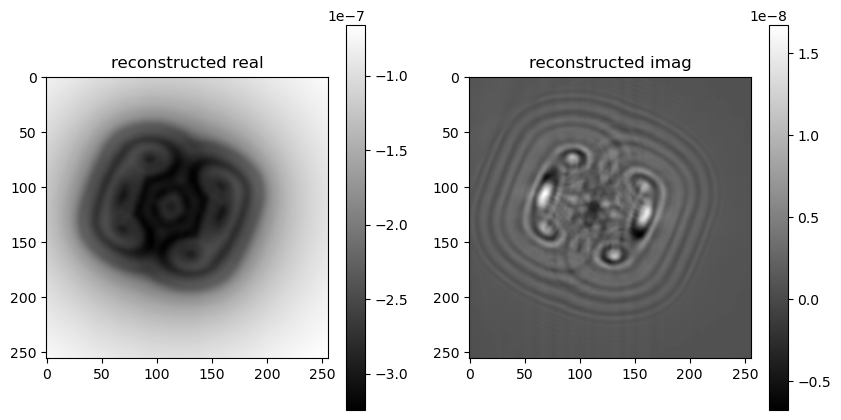

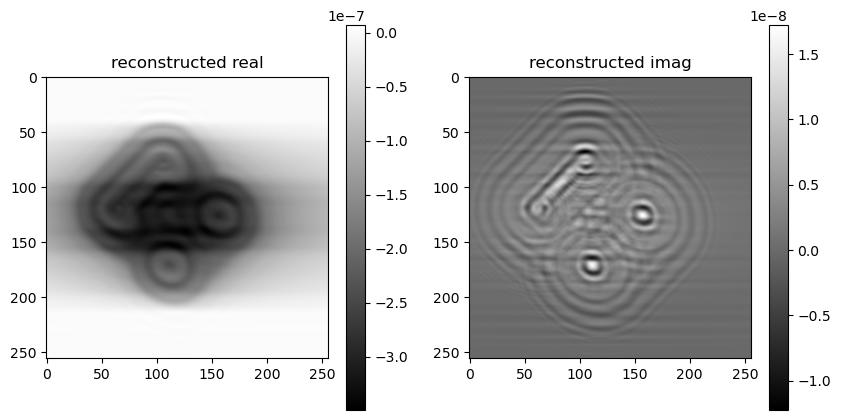

4) gamma=1, err=3.77511e-04
8) gamma=1, err=1.49470e-04
12) gamma=1, err=6.33571e-05
16) gamma=1, err=2.30692e-05


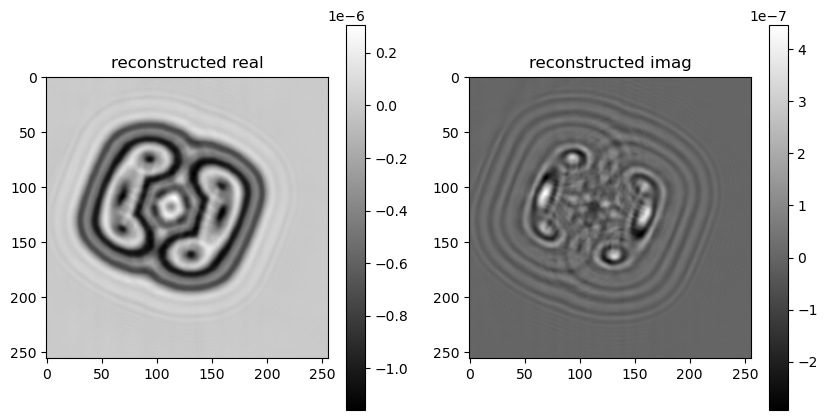

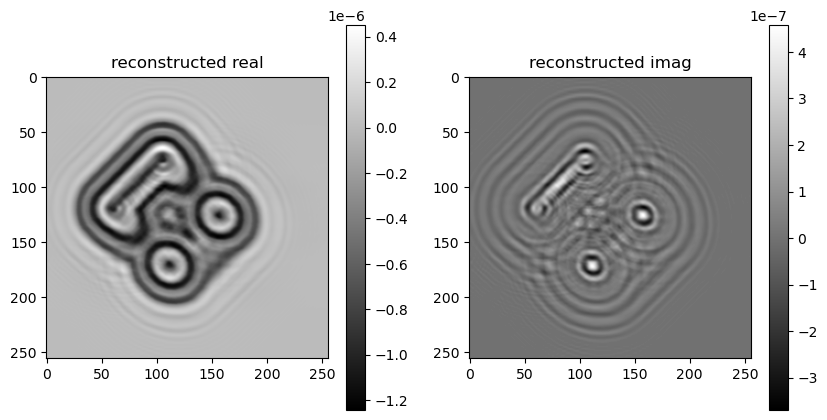

20) gamma=1, err=8.69821e-06
24) gamma=1, err=3.74654e-06
28) gamma=1, err=2.10016e-06
32) gamma=1, err=1.38202e-06


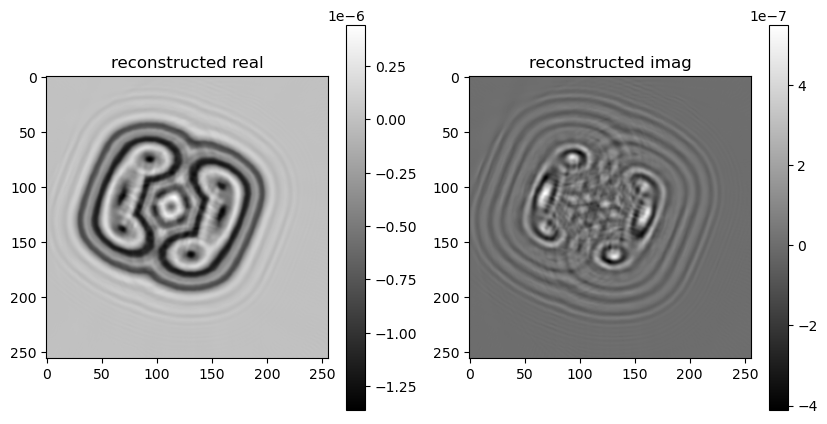

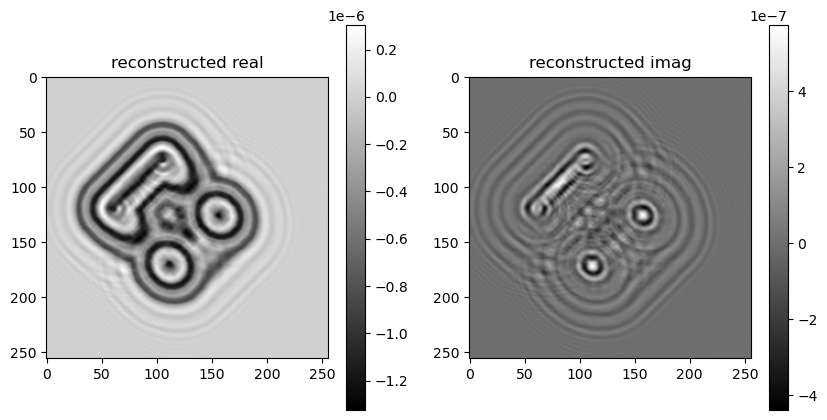

36) gamma=1, err=1.05763e-06
40) gamma=1, err=8.59045e-07
44) gamma=1, err=7.70965e-07
48) gamma=1, err=7.14379e-07


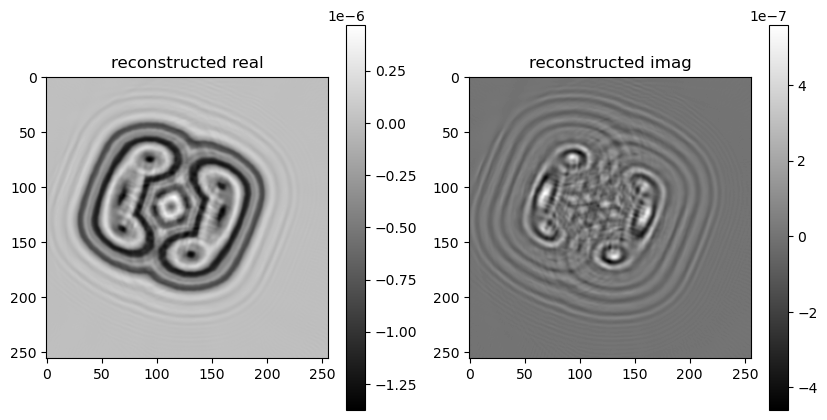

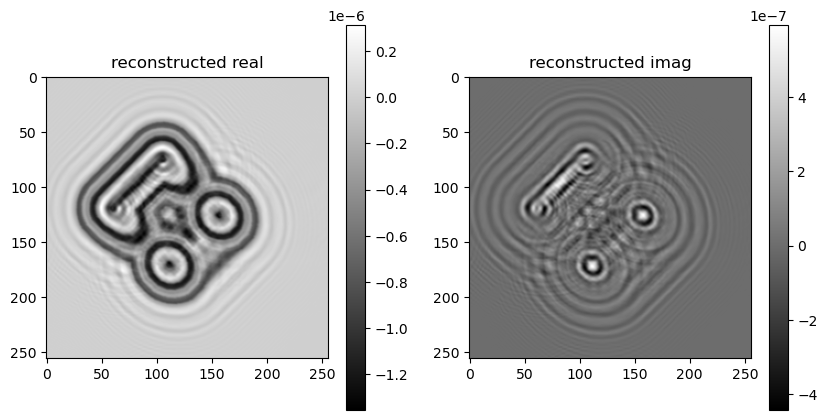

52) gamma=1, err=6.89647e-07
56) gamma=1, err=6.74187e-07
60) gamma=1, err=6.66096e-07
64) gamma=1, err=6.61550e-07


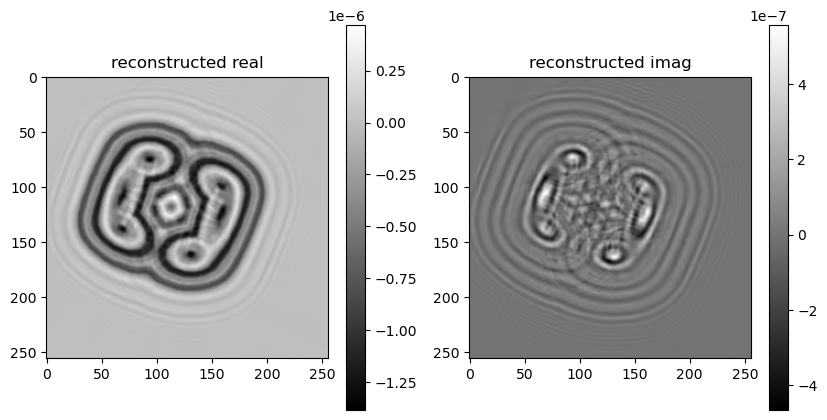

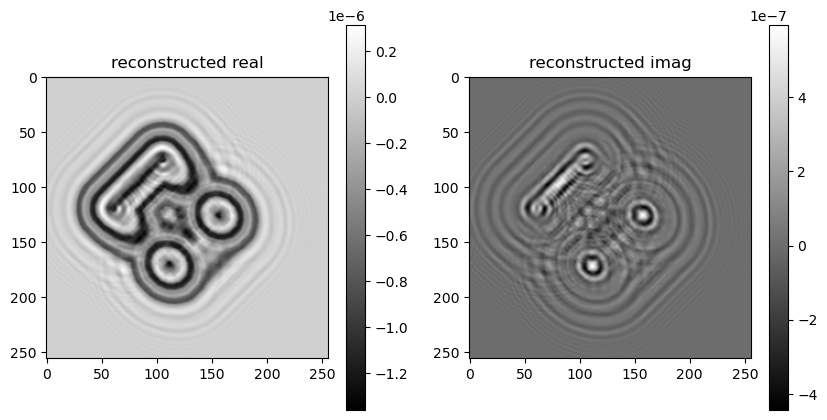

68) gamma=1, err=6.58527e-07
72) gamma=1, err=6.56722e-07
76) gamma=1, err=6.55460e-07
80) gamma=1, err=6.54179e-07


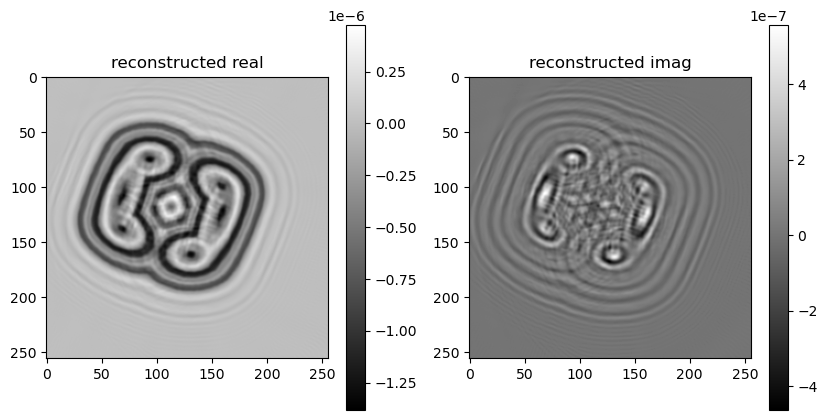

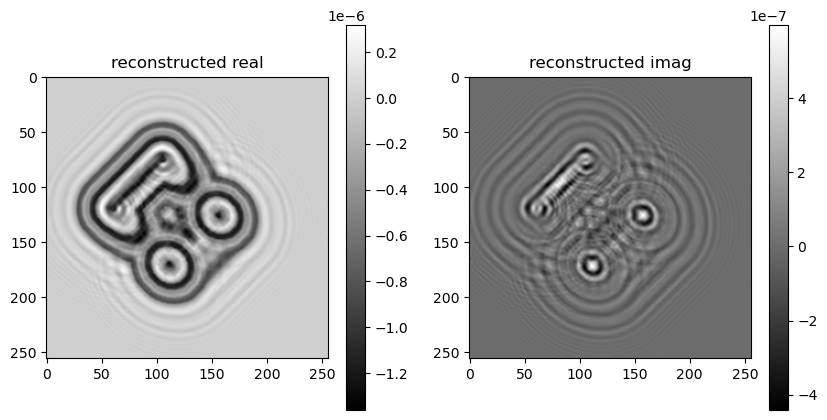

84) gamma=1, err=6.53099e-07
88) gamma=1, err=6.52144e-07
92) gamma=1, err=6.51196e-07
96) gamma=1, err=6.49900e-07


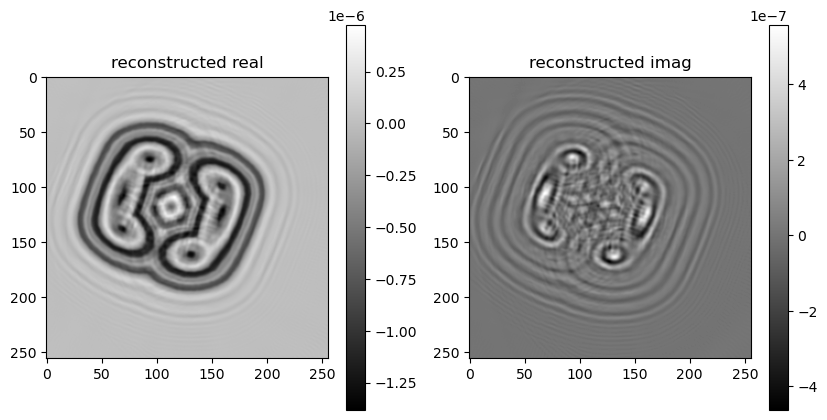

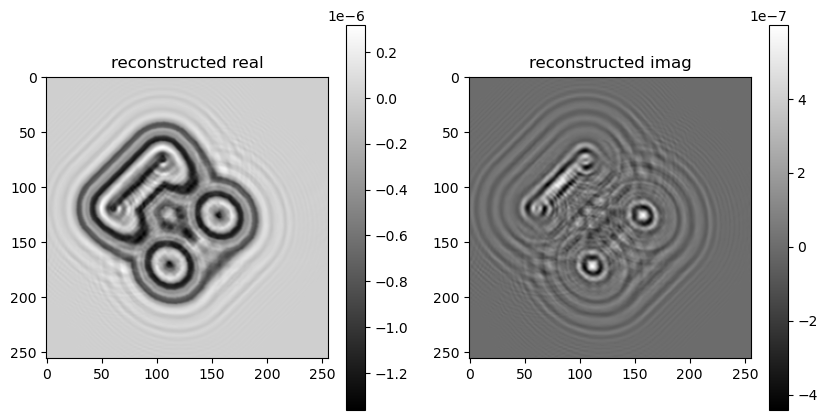

100) gamma=1, err=6.48684e-07
104) gamma=1, err=6.47246e-07
108) gamma=1, err=6.45885e-07
112) gamma=1, err=6.44627e-07


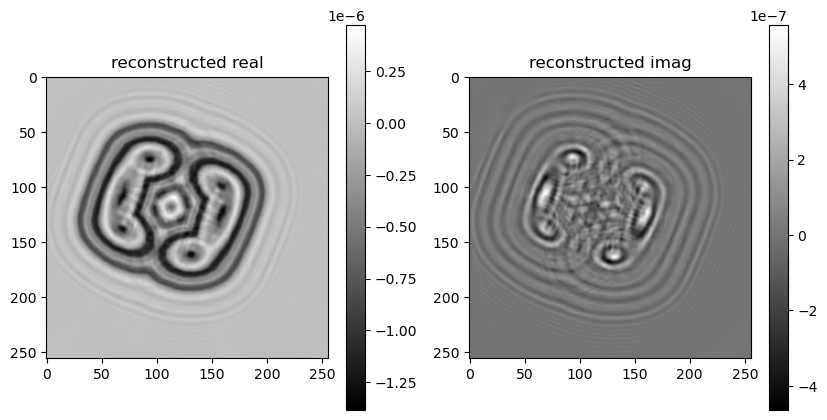

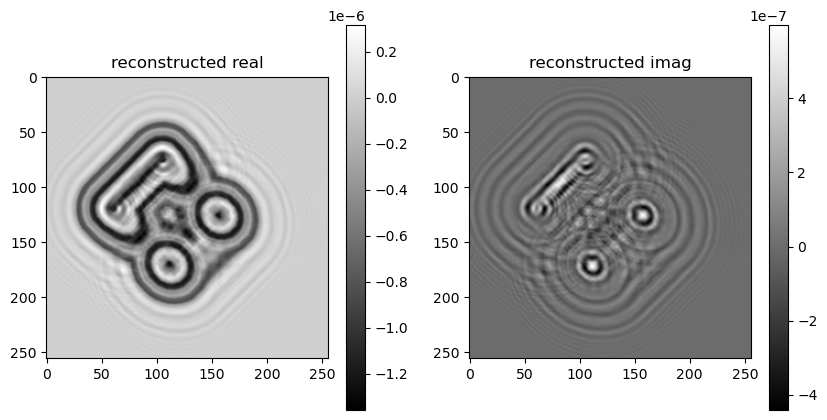

116) gamma=1, err=6.43755e-07
120) gamma=1, err=6.42810e-07
124) gamma=1, err=6.42026e-07
128) gamma=1, err=6.41370e-07


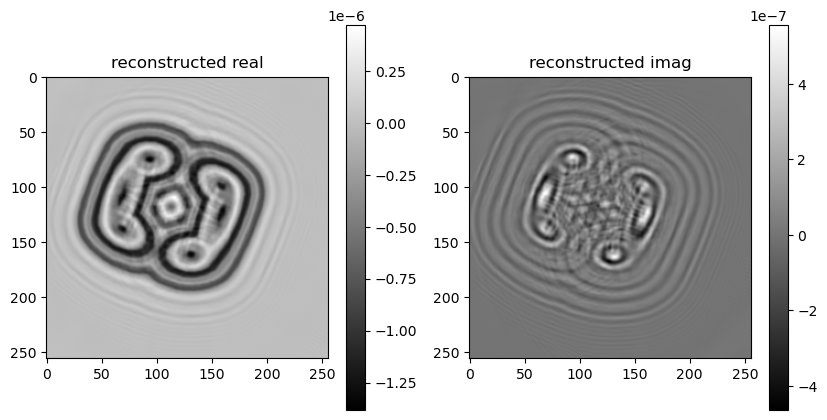

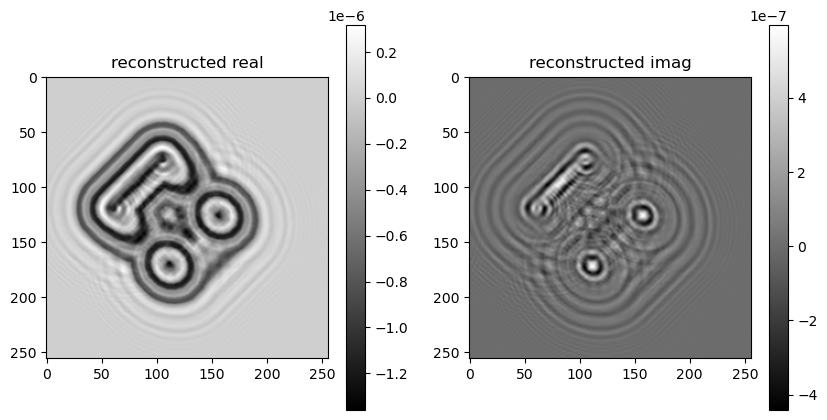

In [7]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma

def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional
    @gpu_batch
    def _minf(Ru,data):
        res = cp.empty(data.shape[0],dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(Ru[k]-data[k])**2
        return res
    
    def minf(Ru):
        res = np.sum(_minf(Ru,data))
        return res
    
    u = init.copy()
    conv = np.zeros(1+pars['niter']//pars['err_step'])
    center = u.shape[-1]//2
    for i in range(pars['niter']):
        fu = R(u,theta,center)
        grad = RT(fu-data,theta,center)/np.float32(ne*ntheta)
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d,grad,grad0)

        grad0 = grad
        fd = R(d, theta, center)
        gamma = line_search(minf, pars['gamma'], fu, fd)
        u = linear(u,d,1,gamma)
        if i % pars['err_step'] == 0:
            fu = R(u, theta, center)
            err = minf(fu)
            conv[i//pars['err_step']] = err
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow(u[u.shape[0]//2,ne//4:-ne//4,ne//4:-ne//4])
            mshow(u[:,ne//2+ne//4+2,ne//4:-ne//4])

    return u, conv


pars = {'niter': 129, 'err_step': 4, 'vis_step': 16, 'gamma': 1}

# if by chunk on gpu
# rec = np.zeros([ne,ne,ne],dtype='complex64')
# data_rec = data.swapaxes(0,1)

data = logtomo(psi)
# if fully on gpu
rec = cp.zeros([ne,3*ne//2,3*ne//2],dtype='complex64')
data_rec = cp.pad(cp.array(data.swapaxes(0,1)),((0,0),(0,0),(ne//4,ne//4)),'edge')
rec, conv = cg_tomo(data_rec, rec, pars)

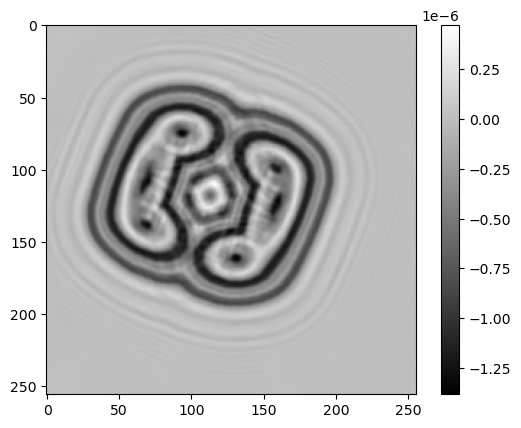

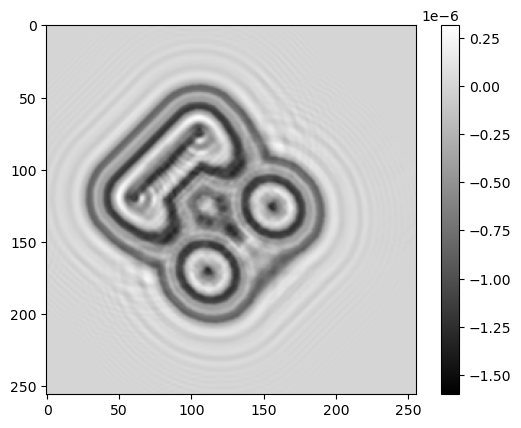

In [8]:
plt.imshow(rec[rec.shape[0]//2,ne//4:-ne//4,ne//4:-ne//4].real.get(),cmap='gray')
plt.colorbar()
plt.show()
plt.imshow(rec[:,ne//2+ne//4+2,ne//4:-ne//4].real.get(),cmap='gray',vmin=-1.6e-6)
plt.colorbar()
plt.show()
dxchange.write_tiff(np.real(rec).get(),f'data/rec_{npos}pos/u_2step',overwrite=True)